# Pointing game

In [1]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
from ast import literal_eval
from scipy.signal import convolve2d

import cv2
from CorrRELAX import ImageIO
from CorrRELAX.WindowOps import create_kernel

from tqdm.notebook import tqdm
from skimage.transform import resize

In [ ]:
imagepath = ""  # Image directory with vindr Dataset images processed with our method
csvpath = "finding_annotations_V2.csv"
LABEL_NAMES = [
    "No Finding",
    "Mass",
    "Suspicious Calcification",
    "Asymmetries",
    "Architectural Distortion",
    "Suspicious Lymph Node",
    "Skin Thickening",
    "Retractions",
]
evalpath = "output/PG_w256_s32_m1280"

window_size = 256
window_shape = (window_size, window_size)
stride = 32
batch_size = 32
n_masks = 1280
mask_size = 8
mask_shape = (mask_size, mask_size)

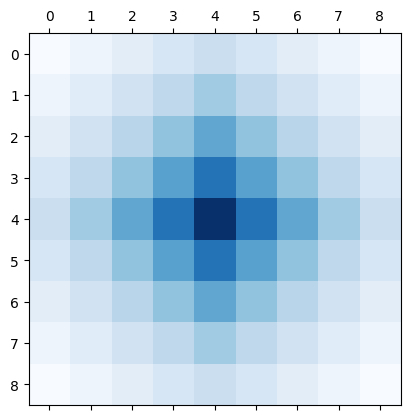

In [3]:
kernel = create_kernel(window_size, stride)
plt.matshow(kernel, cmap="Blues")

In [4]:
# cargamos el csv
df = pd.read_csv(csvpath)
df = df.groupby("split").get_group("test")  # Solo obtener el test split
df = df[df["finding_categories"] != "['No Finding']"]
grupos = df.groupby(["study_id", "image_id"])
print(len(grupos))

357


In [ ]:
# Funcion para obtener las predicciones segun efecto de ventanas vecinas
def apply_kernel(predmap, kernel, image_shape, window_size):
    halfwindow = window_size // 2
    outshape = image_shape + np.array([window_size] * 2)
    convmap = convolve2d(predmap, kernel, mode="full")
    resized = resize(
        convmap,
        output_shape=outshape,
        mode="reflect",
        anti_aliasing=True,
        preserve_range=True,
    )
    return resized[halfwindow:-halfwindow, halfwindow:-halfwindow]

## Aplicado a una imagen

In [6]:
# obtenemos la lista de los archivos ya procesados al momento
files = glob(os.path.join(evalpath, "*.npz"))
rand_file = np.random.choice(files)
print(rand_file)
image_id = os.path.basename(rand_file).split(".")[0]

sample = df.groupby("image_id").get_group(image_id)
sample

output/PG_w256_s32_m1280/68e4a2c85b46b78118fd2dac46a9afbb.npz


,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,finding_birads,xmin,ymin,xmax,ymax,split
1023,1a6eb4bb66e7e5a47d9191e0aa13930e,3091650b88bd4b9e1f284a63d871e788,68e4a2c85b46b78118fd2dac46a9afbb,L,MLO,3518,2800,BI-RADS 4,DENSITY C,['Suspicious Calcification'],BI-RADS 4,188.731995,1561.800049,237.837006,1693.01001,test


In [9]:
# Cargamos el archivo
data = np.load(rand_file)

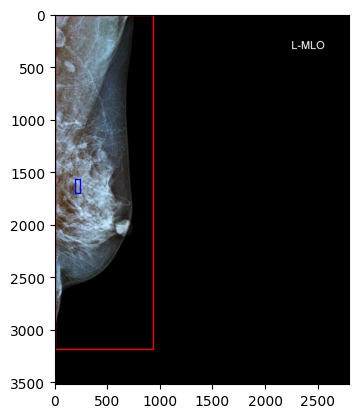

In [ ]:
# cargamos la imagen
study_id = sample["study_id"].unique()[0]
# print(study_id)
impath = os.path.join(imagepath, study_id, f"{image_id}.png")
image = ImageIO.load_image(impath)

# Obtenemos el ROI de la imagen, incluido en el archivo (para no tener que reprocesar)
roi = data["BreastROI"]  # (xmin, ymin, xmax, ymax)

fig, ax = plt.subplots()
ax.imshow(image)
rect = Rectangle(
    (roi[0], roi[1]),
    roi[2] - roi[0],
    roi[3] - roi[1],
    linewidth=1,
    edgecolor="r",
    facecolor="none",
)
ax.add_patch(rect)

# dibujaremos los bbox originales, para tener una referencia visual post_crop
for idx, row in sample.iterrows():
    rect = Rectangle(
        (row["xmin"], row["ymin"]),
        row["xmax"] - row["xmin"],
        row["ymax"] - row["ymin"],
        linewidth=1,
        edgecolor="b",
        facecolor="none",
    )
    ax.add_patch(rect)


            xmin         ymin        xmax        ymax
1023  186.731995  1561.800049  235.837006  1693.01001


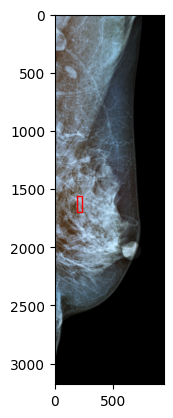

In [ ]:
# corregimos el bbox original, respecto al roi
cropped = image[roi[1] : roi[3], roi[0] : roi[2]]
find_bbox = sample[["xmin", "ymin", "xmax", "ymax"]] - np.array(
    [roi[0], roi[1], roi[0], roi[1]]
)
print(find_bbox)

fig, ax = plt.subplots()
ax.imshow(cropped)
for box in find_bbox.values:
    rect = Rectangle(
        (box[0], box[1]),
        box[2] - box[0],
        box[3] - box[1],
        linewidth=1,
        edgecolor="r",
        facecolor="none",
    )
    ax.add_patch(rect)


In [ ]:
predmaps = {
    label: apply_kernel(
        data["Predictions"][..., i], kernel, cropped.shape[:2], window_size
    )
    for i, label in enumerate(LABEL_NAMES)
}
corrmaps = {
    label: apply_kernel(
        data["CorrPred"][..., i], kernel, cropped.shape[:2], window_size
    )
    for i, label in enumerate(LABEL_NAMES)
}

In [ ]:
# Obtenemos el maximo local del mapa de prediccion y de correlacion
true_pred_dets = np.zeros_like(LABEL_NAMES, dtype=bool)
true_corr_dets = np.zeros_like(LABEL_NAMES, dtype=bool)

hh, ww = cropped.shape[:2]

for i, label in enumerate(LABEL_NAMES):
    pmax, cmax = np.max(predmaps[label]), np.max(corrmaps[label])
    # y su localizacion
    py, px = np.argwhere(predmaps[label] == pmax)[0].squeeze()
    cy, cx = np.argwhere(corrmaps[label] == cmax)[0].squeeze()

    # Revisaremos si dentro de cada registro de la muestra existe un hallazgo de este tipo:
    for _, row in sample.iterrows():
        # desempaquetamos las etiquetas
        find_annots = literal_eval(row.finding_categories)
        if label in find_annots:
            # Si existe, obtenemos el bbox (corregido respecto al roi)
            find_bbox = (
                row[["xmin", "ymin", "xmax", "ymax"]]
                - np.array([roi[0], roi[1], roi[0], roi[1]])
            ).to_numpy(dtype=int)
            # Le damos un margen del tamaño del stride para evaluar respecto de la localizacion del maximo
            find_bbox = np.clip(
                find_bbox + np.array([-stride, -stride, stride, stride]),
                np.zeros(4, dtype=int),
                np.array([ww, hh, ww, hh]),
            )

            # Evaluamos si el punto maximo se encuentra dentro del bbox
            pred_in_box = (find_bbox[0] <= px < find_bbox[2]) and (
                find_bbox[1] <= py < find_bbox[3]
            )
            corr_in_box = (find_bbox[0] <= cx < find_bbox[2]) and (
                find_bbox[1] <= cy < find_bbox[3]
            )

            # Si se encuentra dentro, marcamos como verdadero
            if pred_in_box:
                true_pred_dets[i] = True
            if corr_in_box:
                true_corr_dets[i] = True

print(true_pred_dets)
print(true_corr_dets)

[False False  True False False False False False]
[False False False False False False False False]


## A conjunto completo

In [ ]:
files = glob(os.path.join(evalpath, "*.npz"))
all_pred_dets = []
all_corr_dets = []
all_available_dets = []

for file in tqdm(files):
    data = np.load(file)  # Cargamos el archivo
    image_id = os.path.basename(file).split(".")[0]  # Obtenemos el id de la imagen
    sample = df.groupby("image_id").get_group(
        image_id
    )  # Obtenemos el grupo de la imagen
    # study_id = sample["study_id"].unique()[0] # Obtenemos el id del estudio
    # impath = os.path.join(imagepath, study_id, f"{image_id}.png") # Obtenemos la ruta de la imagen
    # image = ImageIO.load_image(impath) # Cargamos la imagen
    roi = data["BreastROI"]  # Obtenemos el ROI (xmin, ymin, xmax, ymax)
    crop_size = (roi[3] - roi[1], roi[2] - roi[0])  # Obtenemos el tamaño del recorte
    hh, ww = crop_size  # Obtenemos las dimensiones del recorte

    # Obtenemos los mapas de predicciones y correlaciones
    predmaps = {
        label: apply_kernel(data["Predictions"][..., i], kernel, crop_size, window_size)
        for i, label in enumerate(LABEL_NAMES)
    }
    corrmaps = {
        label: apply_kernel(data["CorrPred"][..., i], kernel, crop_size, window_size)
        for i, label in enumerate(LABEL_NAMES)
    }

    # Obtenemos el maximo local del mapa de prediccion y de correlacion
    true_pred_dets = np.zeros_like(LABEL_NAMES, dtype=bool)
    true_corr_dets = np.zeros_like(LABEL_NAMES, dtype=bool)
    available_dets = np.zeros_like(LABEL_NAMES, dtype=bool)

    for i, label in enumerate(LABEL_NAMES):
        pmax, cmax = (
            np.max(predmaps[label]),
            np.max(corrmaps[label]),
        )  # Obtenemos el maximo de cada mapa
        # y la localizacion de estos
        py, px = np.argwhere(predmaps[label] == pmax)[0].squeeze()
        cy, cx = np.argwhere(corrmaps[label] == cmax)[0].squeeze()

        # Revisaremos si dentro de cada registro de la muestra existe un hallazgo de este tipo:
        for _, row in sample.iterrows():
            find_annots = literal_eval(
                row.finding_categories
            )  # desempaquetamos las etiquetas
            if label in find_annots:
                # Como existe un hallazgo de este tipo, marcamos como disponible
                available_dets[i] = True
                # Si existe un hallazgo de este tipo, obtenemos el bbox (corregido respecto al roi)
                find_bbox = (
                    row[["xmin", "ymin", "xmax", "ymax"]]
                    - np.array([roi[0], roi[1], roi[0], roi[1]])
                ).to_numpy(dtype=int)
                # Le damos un margen del tamaño del stride para evaluar respecto de la localizacion del maximo
                find_bbox = np.clip(
                    find_bbox + np.array([-stride, -stride, stride, stride]),
                    np.zeros(4, dtype=int),
                    np.array([ww, hh, ww, hh]),
                )

                # Evaluamos si el punto maximo se encuentra dentro del bbox
                pred_in_box = (
                    (find_bbox[0] <= px < find_bbox[2])
                    and (find_bbox[1] <= py < find_bbox[3])
                ) and pmax >= 0.25
                corr_in_box = (
                    (find_bbox[0] <= cx < find_bbox[2])
                    and (find_bbox[1] <= cy < find_bbox[3])
                ) and cmax > 0.05

                # Si se encuentra dentro, marcamos como verdadero
                if pred_in_box:
                    true_pred_dets[i] = True
                if corr_in_box:
                    true_corr_dets[i] = True

    # Finalmente habiendo revisado todos los hallazgos de la imagen, guardamos los resultados
    all_pred_dets.append(true_pred_dets)
    all_corr_dets.append(true_corr_dets)
    all_available_dets.append(available_dets)

  0%|          | 0/357 [00:00<?, ?it/s]

In [7]:
np.array(all_available_dets).sum(axis=0)

array([  0, 219, 105,  78,  24,  10,  12,   8])

In [ ]:
pred_point = np.array(all_pred_dets)[:, 1:].sum(axis=0) / np.array(all_available_dets)[
    :, 1:
].sum(axis=0)
corr_point = np.array(all_corr_dets)[:, 1:].sum(axis=0) / np.array(all_available_dets)[
    :, 1:
].sum(axis=0)

result_df = pd.DataFrame(
    data={"Predictions": pred_point, "Correlation": corr_point}, index=LABEL_NAMES[1:]
)
print("pmax>50%, cmax>0.05 (correlación positiva)")
result_df

pmax>50%, cmax>0.05 (correlación positiva)


,Predictions,Correlation
Mass,0.269406,0.420091
Suspicious Calcification,0.571429,0.723810
Asymmetries,0.038462,0.346154
Architectural Distortion,0.000000,0.000000
Suspicious Lymph Node,0.200000,0.000000
Skin Thickening,0.416667,0.416667
Retractions,0.000000,0.000000


In [ ]:
percentage = pd.Series(
    (np.array(all_available_dets).sum(axis=0) / len(all_available_dets))[1:],
    index=LABEL_NAMES[1:],
)

In [ ]:
(
    (result_df["Predictions"] * percentage).sum(),
    (result_df["Correlation"] * percentage).sum(),
)

(0.6358543417366948, 0.5602240896358542)

In [ ]:
pred_point = np.array(all_pred_dets)[:, 1:].sum(axis=0) / np.array(all_available_dets)[
    :, 1:
].sum(axis=0)
corr_point = np.array(all_corr_dets)[:, 1:].sum(axis=0) / np.array(all_available_dets)[
    :, 1:
].sum(axis=0)

result_df = pd.DataFrame(
    data={"Predictions": pred_point, "Correlation": corr_point}, index=LABEL_NAMES[1:]
)
print("Resultado con threshold (pred > 0.25 y correlacion positiva > 0.1)")
result_df

Resultado con threshold (pred > 0.25 y correlacion positiva > 0.1)


,Predictions,Correlation
Mass,0.520548,0.420091
Suspicious Calcification,0.771429,0.723810
Asymmetries,0.269231,0.346154
Architectural Distortion,0.000000,0.000000
Suspicious Lymph Node,0.400000,0.000000
Skin Thickening,0.583333,0.416667
Retractions,0.000000,0.000000


In [ ]:
pred_point = np.array(all_pred_dets)[:, 1:].sum(axis=0) / np.array(all_available_dets)[
    :, 1:
].sum(axis=0)
corr_point = np.array(all_corr_dets)[:, 1:].sum(axis=0) / np.array(all_available_dets)[
    :, 1:
].sum(axis=0)

result_df = pd.DataFrame(
    data={"Predictions": pred_point, "Correlation": corr_point}, index=LABEL_NAMES[1:]
)
print("Resultado con threshold (pred > 0.5 y correlacion positiva > 0.1)")
result_df

Resultado con threshold (pred > 0.5 y correlacion positiva > 0.1)


,Predictions,Correlation
Mass,0.269406,0.420091
Suspicious Calcification,0.571429,0.647619
Asymmetries,0.038462,0.346154
Architectural Distortion,0.000000,0.000000
Suspicious Lymph Node,0.200000,0.000000
Skin Thickening,0.416667,0.416667
Retractions,0.000000,0.000000


In [ ]:
pred_point = np.array(all_pred_dets)[:, 1:].sum(axis=0) / np.array(all_available_dets)[
    :, 1:
].sum(axis=0)
corr_point = np.array(all_corr_dets)[:, 1:].sum(axis=0) / np.array(all_available_dets)[
    :, 1:
].sum(axis=0)

result_df = pd.DataFrame(
    data={"Predictions": pred_point, "Correlation": corr_point}, index=LABEL_NAMES[1:]
)
print("Resultado con maximo puro")
result_df

Resultado con maximo puro


,Predictions,Correlation
Mass,0.557078,0.420091
Suspicious Calcification,0.895238,0.733333
Asymmetries,0.602564,0.346154
Architectural Distortion,0.375000,0.000000
Suspicious Lymph Node,0.700000,0.000000
Skin Thickening,0.916667,0.416667
Retractions,0.750000,0.000000


In [ ]:
pred_point = np.array(all_pred_dets)[:, 1:].sum(axis=0) / np.array(all_available_dets)[
    :, 1:
].sum(axis=0)
corr_point = np.array(all_corr_dets)[:, 1:].sum(axis=0) / np.array(all_available_dets)[
    :, 1:
].sum(axis=0)

result_df = pd.DataFrame(
    data={"Predictions": pred_point, "Correlation": corr_point}, index=LABEL_NAMES[1:]
)
print("Resultado con maximo puro")
result_df

Resultado con maximo puro


,Predictions,Correlation
Mass,0.557078,0.420091
Suspicious Calcification,0.895238,0.723810
Asymmetries,0.602564,0.346154
Architectural Distortion,0.375000,0.000000
Suspicious Lymph Node,0.700000,0.000000
Skin Thickening,0.916667,0.416667
Retractions,0.750000,0.000000


In [ ]:
percentage

Mass                        0.613445
Suspicious Calcification    0.294118
Asymmetries                 0.218487
Architectural Distortion    0.067227
Suspicious Lymph Node       0.028011
Skin Thickening             0.033613
Retractions                 0.022409
dtype: float64

In [ ]:
(
    (result_df["Predictions"] * percentage).sum(),
    (result_df["Correlation"] * percentage).sum(),
)

(0.8291316526610646, 0.5602240896358542)

In [11]:
result_df.style.format("{:.3%}")

,Predictions,Correlation
Mass,55.155%,43.299%
Suspicious Calcification,92.208%,75.325%
Asymmetries,57.143%,33.929%
Architectural Distortion,35.000%,0.000%
Suspicious Lymph Node,70.000%,0.000%
Skin Thickening,91.667%,41.667%
Retractions,75.000%,0.000%


dibujos de prueba

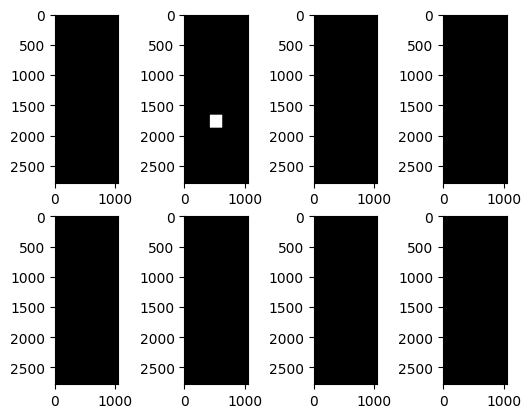

In [33]:
fig, ax = plt.subplot_mosaic(np.array(LABEL_NAMES).reshape(2, -1))
for i, label in enumerate(LABEL_NAMES):
    ax[label].imshow(labelmaps[label], cmap="gray")

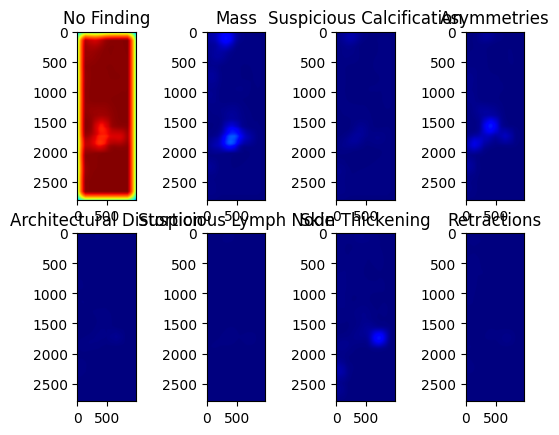

In [12]:
fig, ax = plt.subplot_mosaic(np.array(LABEL_NAMES).reshape(2, -1))
for i, label in enumerate(LABEL_NAMES):
    ax[label].imshow(predmaps[label], cmap="jet", vmin=0, vmax=1)
    ax[label].set_title(label)